# timesformer 파인튜닝  

Timesformer-L 모델(K600 데이터셋):  
96frames, 224 사이즈
   
Timesformer-HR 모델:  
16frames, 448 사이즈 
  
Timesformer 기본 모델:
8frames, 224 사이즈

왠만하면 CLIPS은 1, BATCH는 4로 고정하는게 좋을듯(그게 가장 시간절약)

✅ 2404 samples found in D:\golfDataset\dataset\train (balanced=True)
✅ 295 samples found in D:\golfDataset\dataset\test (balanced=False)


  train acc: 53.827%, loss: 0.1908
  ✔ Model saved: epochs\epoch_1.pth


  test  acc: 49.153%


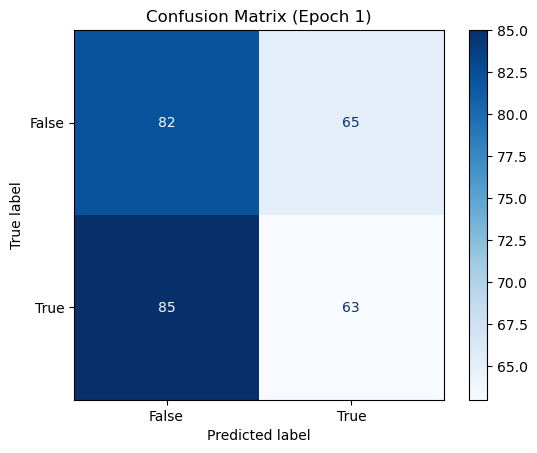

  train acc: 65.017%, loss: 0.1536
  ✔ Model saved: epochs\epoch_2.pth


  test  acc: 51.864%


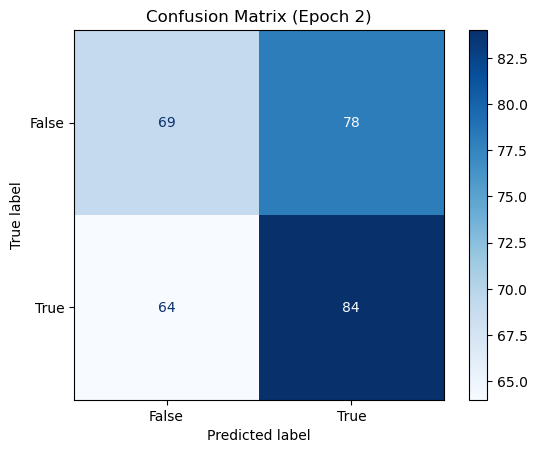

  train acc: 74.459%, loss: 0.1214
  ✔ Model saved: epochs\epoch_3.pth


  test  acc: 53.220%


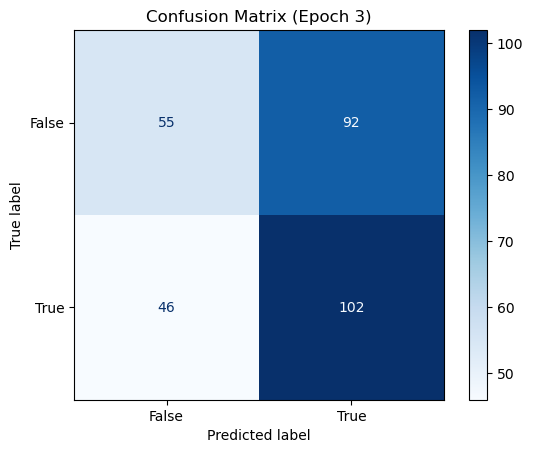

Epoch 3 [Batch]:  19%|▏| 113/601 [09:51<35:07,  4.32s/it, Batch=113, L

In [ ]:
import sys
sys.path.append(r"D:\timesformer")

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as T
from torchvision.transforms import functional as F, InterpolationMode
from pathlib import Path
import numpy as np
import random
from decord import VideoReader
from tqdm import tqdm
from timesformer.models.vit import TimeSformer
import pickle
import matplotlib.pyplot as plt
torch.cuda.empty_cache()

# ----------------- 하이퍼파라미터 및 경로 ----------------------------
TRAIN_ROOT = Path(r"D:\golfDataset\dataset\train")
TEST_ROOT  = Path(r"D:\golfDataset\dataset\test")
PRETRAIN_PTH = Path(r"D:\timesformer\pretrained\TimeSformer_divST_8x32_224_K600.pyth")
NUM_FRAMES = 8
IMG_SIZE = 224
CLIPS_PER_VIDEO = 1
# ----------------- 조정 가능 파라미터 ----------------------------
BATCH_SIZE = 4
LR = 1e-6
WEIGHT_DECAY = 0.1
DROPOUT = 0.7
TF_RATIO = [2.0, 1.0]
TRAIN_BLOCK = 12 

EPOCHS = 5
SEED = 42
EPOCHS_DIR = Path("epochs")
EPOCHS_DIR.mkdir(exist_ok=True)
CHECKPOINT_PATH = Path("checkpoint.pth")

# ----------------- 재현성 ----------------------------
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

import torchvision.transforms as T

# ----------------- 데이터 증강 transform 정의 ----------------------------
train_transform = T.Compose([
    T.ToPILImage(),
    T.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    T.RandomHorizontalFlip(),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    T.ToTensor(),
    T.Normalize([0.45]*3, [0.225]*3)
])

test_transform = T.Compose([
    T.ToPILImage(),
    T.Resize(256, interpolation=InterpolationMode.BICUBIC),
    T.CenterCrop(IMG_SIZE),
    T.ToTensor(),
    T.Normalize([0.45]*3, [0.225]*3)
])

# ----------------- 전처리 함수 수정 ----------------------------
def preprocess_tensor(img_tensor, train=True):
    if train:
        img = train_transform(img_tensor)
    else:
        img = test_transform(img_tensor)
    return img

def uniform_sample(L, N):
    if L >= N:
        return np.linspace(0, L-1, N).astype(int)
    return np.pad(np.arange(L), (0, N-L), mode='edge')

# ----------------- load_clip 함수 수정 ----------------------------
def load_clip(path: Path, train=True):
    vr = VideoReader(str(path))
    L = len(vr)
    seg_edges = np.linspace(0, L, CLIPS_PER_VIDEO + 1, dtype=int)
    clips = []
    for s0, s1 in zip(seg_edges[:-1], seg_edges[1:]):
        idx = uniform_sample(s1 - s0, NUM_FRAMES) + s0
        arr = vr.get_batch(idx).asnumpy().astype(np.uint8)
        clip = torch.from_numpy(arr).permute(0, 3, 1, 2).float() / 255.0
        clip = torch.stack([preprocess_tensor(f, train=train) for f in clip])
        clips.append(clip.permute(1, 0, 2, 3))
    return clips

# ----------------- 모델 ----------------------------
class TimeSformerWithDropout(nn.Module):
    def __init__(self, base_model, dropout_p=DROPOUT):
        super().__init__()
        self.base = base_model
        self.dropout = nn.Dropout(dropout_p)
        self.head = base_model.model.head

    def forward(self, x):
        feats = self.base.model.forward_features(x)
        out = self.dropout(feats)
        return self.head(out)
    
# ----------------- GolfSwingDataset 클래스 수정 ----------------------------
class GolfSwingDataset(Dataset):
    def __init__(self, root: Path, balance, train=True):
        self.samples = []
        self.train = train
        true_samples = []
        false_samples = []
        for label, sub in [(1, "balanced_true"), (0, "false")]:
            for p in (root/sub/"crop_video").glob("*.mp4"):
                if label == 1:
                    true_samples.append((p, 1))
                else:
                    false_samples.append((p, 0))
        if balance:
            n_true = len(true_samples)
            n_false = len(false_samples)
            if n_false > 0 and n_true > n_false:
                factor = n_true // n_false
                remainder = n_true % n_false
                false_samples = false_samples * factor + false_samples[:remainder]
        self.samples = true_samples + false_samples
        random.shuffle(self.samples)
        print(f"✅ {len(self.samples)} samples found in {root} (balanced={balance})")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        clips = load_clip(path, train=self.train)
        return torch.stack(clips), torch.tensor(label)

# ----------------- 데이터셋 생성 시 train/test 구분 인자 전달 ----------------------------
train_dataset = GolfSwingDataset(TRAIN_ROOT, balance=True, train=True)
test_dataset  = GolfSwingDataset(TEST_ROOT, balance=False, train=False)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

# ----------------- 모델 ----------------------------
base_model = TimeSformer(img_size=IMG_SIZE, num_frames=NUM_FRAMES,
                        num_classes=2, attention_type='divided_space_time',
                        pretrained_model=str(PRETRAIN_PTH)).to(DEVICE)
model = TimeSformerWithDropout(base_model, dropout_p=DROPOUT).to(DEVICE)

def get_trainable_params(model):
    # 백본 일부(마지막 TRAIN_BLOCK개 블록)와 헤드만 학습
    params = []
    total_blocks = 12  # Timesformer 기본 블록 수 (필요시 모델 구조에 맞게 수정)
    for name, param in model.base.model.named_parameters():
        # 마지막 TRAIN_BLOCK개 블록만 학습
        if any(f"blocks.{i}." in name for i in range(total_blocks - TRAIN_BLOCK, total_blocks)):
            param.requires_grad = True
            params.append(param)
        else:
            param.requires_grad = False
    # 헤드는 항상 학습
    for param in model.base.model.head.parameters():
        param.requires_grad = True
        params.append(param)
    return params

# 전체 블록 학습시에는 model.parameters(), 백본 일부 학습시에는 get_trainable_params(model)에 TRAIN_BLOCK 파라미터로 학습 블록 조정
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
criterion = nn.CrossEntropyLoss(weight=torch.tensor(TF_RATIO).to(DEVICE))

# ----------------- Checkpoint 불러오기 ----------------------------
# start_epoch = 0
# if CHECKPOINT_PATH.exists():
#     print(f"🔁 Loading checkpoint from {CHECKPOINT_PATH}")
#     ckpt = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
#     model.load_state_dict(ckpt["model"])
#     optimizer.load_state_dict(ckpt["opt"])
#     start_epoch = ckpt["epoch"] + 1
#     print(f"✅ Resuming from epoch {start_epoch}")
start_epoch = 0

# ----------------- 학습 및 각 epoch별 모델 저장/테스트 ----------------------------
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

train_logs = {"train_acc": [], "test_acc": [], "train_loss": []}
test_acc_per_epoch = []

for epoch in range(start_epoch, EPOCHS):
    model.train()
    total = correct = total_loss = 0
    batch_bar = tqdm(train_loader, desc=f"Epoch {epoch} [Batch]", ncols=70, leave=False)
    for batch_idx, (clips, label) in enumerate(batch_bar):
        # clips shape: (B, CLIPS_PER_VIDEO, C, T, H, W)
        B = clips.shape[0]
        clips = clips.view(-1, *clips.shape[2:]).to(DEVICE)  # (B*CLIPS_PER_VIDEO, C, T, H, W)
        labs = label.repeat(CLIPS_PER_VIDEO).to(DEVICE)
        outs = model(clips)
        loss = criterion(outs, labs)
        optimizer.zero_grad(); loss.backward(); optimizer.step()

        total_loss += loss.item()
        total += labs.size(0)
        correct += (outs.argmax(1) == labs).sum().item()
        
        # 서브 로그: 현재 배치, 누적 loss, 누적 acc
        batch_bar.set_postfix({
            "Batch": batch_idx + 1,
            "Loss": f"{total_loss/(batch_idx+1):.4f}",
            "Acc": f"{correct/total:.2%}"
        })

    train_acc = correct / total
    avg_loss = total_loss / total
    train_logs["train_acc"].append(train_acc)
    train_logs["train_loss"].append(avg_loss)
    print(f"  train acc: {train_acc:.3%}, loss: {avg_loss:.4f}")

    # ✔ 각 epoch별 모델 저장
    epoch_model_path = EPOCHS_DIR / f"epoch_{epoch+1}.pth"
    torch.save({
        "epoch": epoch,
        "model": model.state_dict(),
        "opt": optimizer.state_dict(),
    }, epoch_model_path)
    print(f"  ✔ Model saved: {epoch_model_path}")

    # ✔ 테스트 정확도 및 confusion matrix 기록 (test 데이터셋에서)
    all_preds = []
    all_labels = []
    test_total = test_correct = 0
    with torch.no_grad():
        test_bar = tqdm(test_loader, desc=f"Epoch {epoch} [Test]", ncols=70, leave=False)
        for clips, label in test_bar:
            B = clips.shape[0]
            vids = clips.view(-1, *clips.shape[2:]).to(DEVICE)
            labs = label.repeat(CLIPS_PER_VIDEO).to(DEVICE)
            probs = model(vids).softmax(1)
            pred = probs.argmax(1)
            test_total += pred.size(0)
            test_correct += (pred.cpu() == labs.cpu()).sum().item()
            test_bar.set_postfix({
                "Acc": f"{test_correct/test_total:.2%}"
            })
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(labs.cpu().numpy())
    test_acc = test_correct / test_total if test_total > 0 else 0
    train_logs["test_acc"].append(test_acc)
    test_acc_per_epoch.append(test_acc)
    print(f"  test  acc: {test_acc:.3%}")

    # ✔ confusion matrix 출력
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["False", "True"])
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix (Epoch {epoch+1})")
    plt.show()

    # ✔ 로그 저장
    with open("train_logs.pkl", "wb") as f:
        pickle.dump(train_logs, f)

    # ✔ 체크포인트 저장 (삭제)
    # torch.save({
    #     "epoch": epoch,
    #     "model": model.state_dict(),
    #     "opt": optimizer.state_dict(),
    # }, CHECKPOINT_PATH)

# 🔧 최종 학습된 모델 저장
final_model_path = Path("timesformer_finetuned.pth")
torch.save({
    "epoch": EPOCHS - 1,
    "model": model.state_dict(),
    "opt": optimizer.state_dict(),
}, final_model_path)
print(f"\n✅ Final model saved to {final_model_path}")

# ----------------- 전체 epoch별 test 정확도 시각화 ----------------------------
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
plt.plot(range(1, EPOCHS+1), test_acc_per_epoch, marker='o', label="Test Accuracy")
plt.title("Test Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy")
plt.grid(True)
plt.legend()
plt.show()